# nmi | 2024 spring
## quadrature | motion control in computer-aided modeling
## source: "reality check 5" from <u>numerical analysis, 2nd ed</u> (tim sauer).

### introduction


computer-aided modeling and computer-aided manufacturing require precise control of spatial position along a prescribed motion path. use adaptive quadrature to solve a fundamental piece of the problem: equipartition, or the division of an arbitrary path into equal-length subpaths.
</br></br>

in numerical machining problems, it is preferable to maintain constant speed along the path. during each second, progress should be made along an equal length of the machine–material interface. in other motion planning applications, including computer animation, more complicated progress curves may be required: a hand reaching for a doorknob might begin and end with low velocity and have higher velocity in between. robotics and virtual reality applications require the construction of parametrized curves and surfaces to be navigated. building a table of small equal increments in path distance is often a necessary ﬁrst step.
</br>


### problem statement

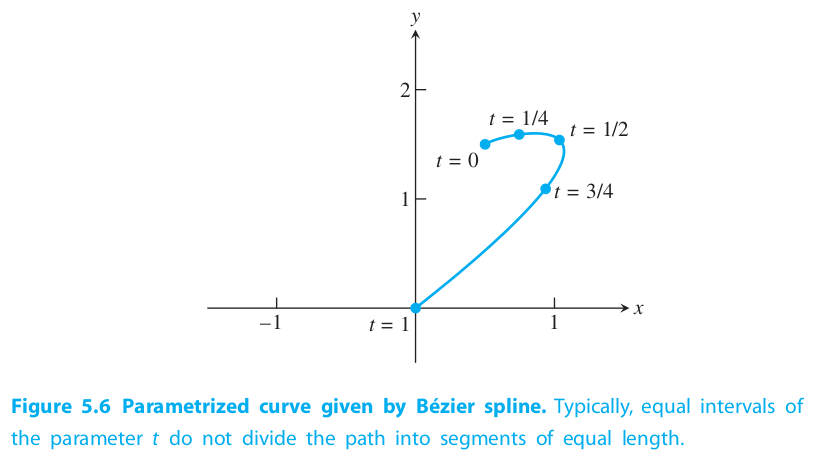

parametric path $P$ is the bézier curve defined by points $(0.5,1.5),(0.6,1.6),(2,2),(0,0)$.
</br></br>

\begin{align}
  P = \left\{\left.
    \begin{array}{l}
      \quad x(t) = 0.5 + 0.3t + 3.9t^2 - 4.7t^3 \\
      \quad y(t) = 1.5 + 0.3t + 0.6t^2 - 2.7t^3
    \end{array}
  \quad \right| \quad 0\le t\le 1 \quad
  \right\}
\end{align}
</br>


 figure 5.6 defines $(x,y)$ at evenly spaced values of $t=0,\frac{1}{4},\frac{1}{2},\frac{3}{4},1$. this does not imply evenly spaced arc length. apply quadrature to divide path into $n$ equal lengths.
 </br></br>

from calculus, arc length:
</br></br>

$$s_{t_1,t_2} = \int_{t_1}^{t_2} \sqrt{x'(t)^2 + y'(t)^2} dt.$$
</br>

rarely does this integral yield a closed-form expression, therefore, an adaptive quadrature controls the parameterization of path.
</br></br>

write a program to equally partition the path into $n$ subpaths <b>with quadrature</b>.

### problem method

<i>while i said that i wasnt really into symbolic coding, a mere two mere derivatives.</i>
</br>


In [ ]:
import sympy as sym

t_sy = sym.symbols('t_sy') # register t for symbolic math
px = 0.5 + 0.3*t_sy + 3.9*t_sy*t_sy - 4.7*pow(t_sy,3) # parameterization of x
py = 1.5 + 0.3*t_sy + 0.6*t_sy*t_sy - 2.7*pow(t_sy,3) # parameterization of y
ds_sy = sym.diff(px,t_sy)*sym.diff(px,t_sy) + pow(sym.diff(py,t_sy),2)
print(f"({sym.diff(px,t_sy)})^2 + ({sym.diff(py,t_sy)})^2")
print(f"==> {sym.simplify(ds_sy)}\n")

ds_sy = sym.sqrt(ds_sy) # incremental arc ds, ***DONT FORGET SQUARE ROOT***

(-14.1*t_sy**2 + 7.8*t_sy + 0.3)^2 + (-8.1*t_sy**2 + 1.2*t_sy + 0.3)^2
==> 264.42*t_sy**4 - 239.4*t_sy**3 + 48.96*t_sy**2 + 5.4*t_sy + 0.18



<i>note: just bc python defaults to a display of 4-5 significant digits does not mean thats all it has in memory. its being thoughtful for your eyes.</i>
</br>


<i>dont forget $\sqrt{}$. which brings us here:</i>
</br></br>

$$S_{t_1,t_2} = \int_{t_1}^{t_2} (264.42t^4 - 239.4t^3 + 48.96t^2 + 5.4t + 0.18)^{\frac{1}{2}} dt$$
</br>



In [ ]:
s = sym.Integral(ds_sy,(t_sy,0.,1.)).evalf()
print(f"evaluated as an integral for t:[0,1] = {s}")

# do some estimates for t
print() # spacer
t = 0.57
s1 = sym.Integral(ds_sy,(t_sy,0.,t)).evalf()
print(f"evaluated as an integral for t:[0,{t}] = {s1}")
t = 0.80
s2 = sym.Integral(ds_sy,(t_sy,0.,t)).evalf()
print(f"evaluated as an integral for t:[0,{t}] = {s2}")
t = 0.92
s3 = sym.Integral(ds_sy,(t_sy,0.,t)).evalf()
print(f"evaluated as an integral for t:[0,{t}] = {s3}")

# to test adaptive quadrature function
print() # spacer
t = 0.1
s1 = sym.Integral(ds_sy,(t_sy,0.,t)).evalf()
print(f"evaluated as an integral for t:[0,{t}] = {s1}")


evaluated as an integral for t:[0,1] = 2.69939402610645

evaluated as an integral for t:[0,0.57] = 0.687971644816615
evaluated as an integral for t:[0,0.8] = 1.36626228332027
evaluated as an integral for t:[0,0.92] = 2.06235789475562

evaluated as an integral for t:[0,0.1] = 0.0728447875355570


<i>so that is the length you want to slice into $n$ pieces <b>with quadrature</b>. so, yes, that integrand is $f(x)$ for quadrature.</i>
</br>


algorithm from lecture 13.

```
# adaptive quadrature, trapezoid

def f_aquad(af,aa,ab,ah0,aeps):
  c = (aa+ab)/2
  s_ab = (ab-aa)/2*(af(aa) + f(ab))
  s_ac = (c-aa)/2*(f(aa) + f(c))
  s_cb = (ab-c)/2*(f(c) + f(ab))
  if (s_ab -(s_ac+s_cb)) < 3*aeps*(ab-aa)/(ah0):
    # accept approximation over [aa,ab]
    pass
  else:
    # recurse
    s_ac = f_aquad(af,aa,c,ah0,aeps)
    s_cb = f_aquad(af,c,ab,ah0,aeps)
  s_ab = s_ac + s_cb
  return s_ab

s = f_aquad(f,a,b,b-a,TOL)
```



In [ ]:
# adaptive quadrature, trapezoid

def f_aquad(af,aa,ab,ah0,aeps):
  c = (aa+ab)/2
  #s_ab = (ab-aa)/2*(af(aa)-af(ab))
  s_ab = (ab-aa)/2*(af.subs(t_sy,aa) + af.subs(t_sy,ab))
  #s_ac = (c-aa)/2*(af(aa)-af(c))
  s_ac = (c-aa)/2*(af.subs(t_sy,aa) + af.subs(t_sy,c))
  #s_cb = (ab-c)/2*(af(c)-af(ab))
  s_cb = (ab-c)/2*(af.subs(t_sy,c) + af.subs(t_sy,ab))
  if (s_ab -(s_ac+s_cb)) < 3*aeps*(ab-aa)/(ah0):
    # accept approximation over [aa,ab]
    pass
  else:
    # recurse
    s_ac = f_aquad(af,aa,c,ah0,aeps)
    s_cb = f_aquad(af,c,ab,ah0,aeps)
  s_ab = s_ac + s_cb
  return s_ab


In [ ]:
# quadrature test
dy = f_aquad(ds_sy,0,.1,.1,1e-10) # small partition bc it took so damned long
print(dy)
dy = f_aquad(ds_sy,0.,1.,1.,1e-7) # this quadrature isnt great at 1e-10!
print(dy)


<i>the real decision of this code is to how to choose $t_0$ and reach the desired length end point.
</br></br>

function f_findt below is the response to "reality check" activity 2, via bisection.</i>
</br>

In [ ]:
import numpy as np

def f_findt(af,al,at1,at2,aeps,aimax):
  isteps = 0
  b = at2
  a = at1

  if a > 0:
    fa = al - f_aquad(af,0,a,a,aeps)
  else:
    fa = al

  while abs((b-a)/2.) > aeps and (isteps < aimax):
    c = (a+b)/2.
    fc = al - f_aquad(af,0,c,c,aeps)
    if fc == 0:
      break
    elif fa*fc < 0:
      b = c
    else:
      a = c
      fa = fc
    isteps += 1

  return c,isteps

def main():
  epsilon = 1e-5
  imax = 200
  t1 = 0.
  t2 = 1.

  n = 4 # as comparative example for t in 4 equi-partitions
  dts = np.zeros(n+1)
  dts[n] = 1.

  ta = t1
  tb = t2*0.57 # estimate to slightly overshoot t of first quarter arc
  for i in range(1,n): # [1,n) bc dont need endpoints
    ds = s*i/n # s is total length, from a few cells previous
    dts[i],isteps = f_findt(ds_sy,ds,ta,tb,epsilon,imax)
    print(f"ds = {ds} at t = {dts[i]} (in interval [{ta},{tb}]) and took {isteps} steps via bisection")
    ta = dts[i]
    tb = t2

  print() # spacer
  print(f"t for {n} equal subpaths: {dts}\n")

  for dt in dts:
    x = px.subs(t_sy,dt)
    y = py.subs(t_sy,dt)
    l = sym.Integral(ds_sy,(t_sy,dts[0],dt)).evalf()
    print(f"at t = {dt}, (x(t),y(t) = ({x},{y}), arc length = {l}")

if __name__ == "__main__":
    main()


ds = 0.674848506526612 at t = 0.5634072875976561 (in interval [0.0,0.57]) and took 15 steps via bisection
ds = 1.34969701305322 at t = 0.802315488466993 (in interval [0.5634072875976561,1.0]) and took 15 steps via bisection
ds = 2.02454551957984 at t = 0.9189787905917882 (in interval [0.802315488466993,1.0]) and took 14 steps via bisection

t for 4 equal subpaths: [0.         0.56340729 0.80231549 0.91897879 1.        ]

at t = 0.0, (x(t),y(t) = (0.500000000000000,1.50000000000000), arc length = 0
at t = 0.5634072875976561, (x(t),y(t) = (1.06643723258219,1.37660782565608), arc length = 0.677207446000698
at t = 0.802315488466993, (x(t),y(t) = (0.823808700527138,0.732482464193851), arc length = 1.37706361194190
at t = 0.9189787905917882, (x(t),y(t) = (0.421669740733063,0.186942727439504), arc length = 2.05517742200879
at t = 1.0, (x(t),y(t) = (0,-0.300000000000000), arc length = 2.69939402610645


### extra credit

<i>this is adaptive trapezoid method. if youd like to improve this, that would be <b>extra credit</b>. any plausible effort, 10pts. any excellent and/or successful effort, more than 10pts. this offer is good until the due date of the semester final.
</br></br>

possible options for improvement: 1) replace bisection with newtons method; 2) replace adaptive quadrature for trapezoid with adaptive quadrature for simpsons or gaussian quadrature; 3) modify the code so that the quadrature approximates [a,b] not [0,b] then [0,a].
</i>
</br>
